<a href="https://colab.research.google.com/github/AjitMallav/brain_tumor_detection/blob/main/BrainTumorCVProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

Dataset

In [3]:
import os

folder_path = '/content/drive/My Drive/Brain_Tumor_Detection'

files = os.listdir(folder_path)
print(files)

['yes', 'no']


EDA (Exploratory Data Analysis)

In [4]:
list_yes = os.listdir("/content/drive/My Drive/Brain_Tumor_Detection/yes")
number_files_yes = len(list_yes)
print("Number of files in 'yes' directory:", number_files_yes)

list_no = os.listdir("/content/drive/My Drive/Brain_Tumor_Detection/no")
number_files_no = len(list_no)
print("Number of files in 'no' directory:", number_files_no)

aug_list_yes = os.listdir("/content/drive/My Drive/augmented_data/yes")
number_aug_files_yes = len(aug_list_yes)
print("Number of files in 'augmented_data/yes' directory:", number_aug_files_yes)

aug_list_no = os.listdir("/content/drive/My Drive/augmented_data/no")
number_aug_files_no = len(aug_list_no)
print("Number of files in 'augmented_data/no' directory:", number_aug_files_no)

print("Number of total yes files:", number_files_yes + number_aug_files_yes)

print("Number of total no files:", number_files_no + number_aug_files_no)

Number of files in 'yes' directory: 1250
Number of files in 'no' directory: 1111
Number of files in 'augmented_data/yes' directory: 1750
Number of files in 'augmented_data/no' directory: 1889
Number of total yes files: 3000
Number of total no files: 3000


Plot of Total Counts


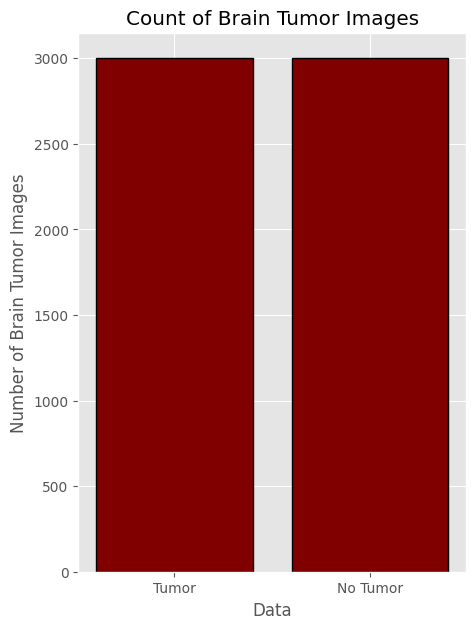

In [5]:
data = {'Tumor': number_files_yes + number_aug_files_yes, 'No Tumor': number_files_no + number_aug_files_no}

typeX = data.keys()
values = data.values()

plot_figure = plt.figure(figsize=(5,7))

plt.bar(typeX, values, color="maroon", edgecolor="black", linewidth=1)

plt.xlabel("Data")
plt.ylabel("Number of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

Data Augumentation

In [6]:
# 3000 (50%), 3000 (50%)

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [8]:
# def timing(sec_elapsed):
#  hours = int(sec_elapsed / (60*60))
#  mins = int(sec_elapsed % (60*60) / 60)
#  sec = sec_elapsed % 60
#
#  return f"{hours}:{mins}:{sec}"

In [9]:
#def augmented_data(file_dir, n_generated_samples, save_to_dir):

    # Initialize the image data generator
#    data_generator = ImageDataGenerator(rotation_range=10,
#                                   width_shift_range=0.1,
#                                   height_shift_range=0.1,
#                                   shear_range=0.1,
#                                   brightness_range=(0.3, 1.0),
#                                   horizontal_flip=True,
#                                   vertical_flip=True,
#                                   fill_mode='nearest')

    # Loop through each file in the source directory
#    for filename in os.listdir(file_dir):
#        img = cv2.imread(file_dir + '/' + filename)
#        img = img.reshape((1,) + img.shape)
#        save = 'aug_' + filename[:-4]
#        i = 0
#
        # Generate and save augmented images
#        for batch in data_generator.flow(x=img, batch_size=1, save_to_dir=save_to_dir, save=save, save_format="jpg"):
#            i += 1
#            if i > n_generated_samples:
#                break

In [10]:
# import time
# start_time = time.time()

# yes_path = '/content/drive/My Drive/Brain_Tumor_Detection/yes'
# no_path = '/content/drive/My Drive/Brain_Tumor_Detection/no'

# augmented_data_path = '/content/drive/My Drive/augmented_data/'

# augmented_data(file_dir=yes_path, n_generated_samples=2, save_to_dir=augmented_data_path+'yes')
# augmented_data(file_dir=no_path, n_generated_samples=3, save_to_dir=augmented_data_path+'no')

# end_time = time.time()
# execution_time = end_time - start_time
# print(timing(execution_time))

In [11]:
def data_summary(main_path):
  yes_path = '/content/drive/My Drive/Brain_Tumor_Detection/yes'
  no_path = '/content/drive/My Drive/Brain_Tumor_Detection/no'

  x_pos = len(os.listdir(yes_path))
  x_neg = len(os.listdir(no_path))

  x = (x_pos + x_neg)

  pos_per = (x_pos*100)/x
  neg_per = (x_neg*100)/x

  print(f"Number of samples: {x}")
  print(f"Number of positive samples in percentage: {pos_per}%")
  print(f"Number of negative samples in percentage: {neg_per}%")


data_summary('/content/drive/My Drive/Brain_Tumor_Detection')

Number of samples: 2361
Number of positive samples in percentage: 52.9436679373147%
Number of negative samples in percentage: 47.0563320626853%


Data Preprocessing

In [12]:
# Crops images to have less empty space
import imutils

def crop_brain_tumor(image, plot=False):
   gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   gray = cv2.GaussianBlur(gray, (5,5), 0)


   thold = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
   thold = cv2.erode(thold, None, iterations=2)
   thold = cv2.dilate(thold, None, iterations=2)


   cnts = cv2.findContours(thold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
   cnts = imutils.grab_contours(cnts)
   c = max(cnts, key=cv2.contourArea)


   ext_Left = tuple(c[c[:,:,0].argmin()][0])
   ext_Right = tuple(c[c[:,:,0].argmax()][0])
   ext_Top = tuple(c[c[:,:,1].argmin()][0])
   ext_Bottom = tuple(c[c[:,:,1].argmax()][0])


   new_image = image[ext_Top[1]:ext_Bottom[1], ext_Left[0]:ext_Right[0]]


   if plot:
       plt.figure()
       plt.subplot(1, 2, 1)
       plt.imshow(image)
       plt.title('Original Image')


       plt.subplot(1, 2, 2)
       plt.imshow(new_image)
       plt.title('Cropped Image')
       plt.show()


   return new_image

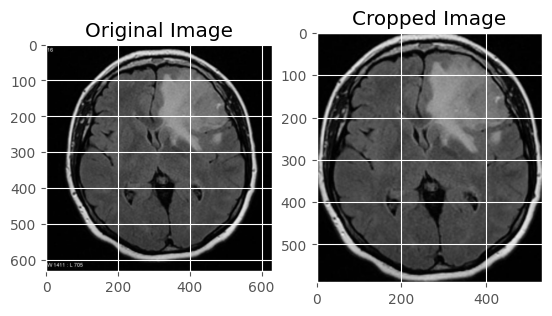

array([[[2, 2, 2],
        [2, 2, 2],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[2, 2, 2],
        [2, 2, 2],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[2, 2, 2],
        [2, 2, 2],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[2, 2, 2],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)
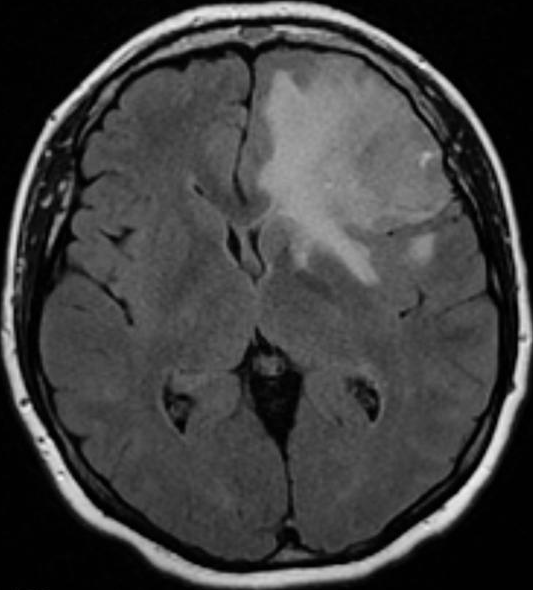

In [13]:
# Use sample file to test if it's working

image = cv2.imread('/content/drive/My Drive/Brain_Tumor_Detection/yes/y1499.jpg')
crop_brain_tumor(image, True)

In [14]:
folder1 = '/content/drive/My Drive/augmented_data/no/'
folder2 = '/content/drive/My Drive/augmented_data/yes/'


# for filename in os.listdir(folder1):
#   img = cv2.imread(folder1 + filename)
#   img = crop_brain_tumor(img, False)
#   cv2.imwrite(folder1 + filename, img)
# for filename in os.listdir(folder2):
#   img = cv2.imread(folder2 + filename)
#   img = crop_brain_tumor(img, False)
#   cv2.imwrite(folder2 + filename, img)

Image Loading

In [15]:
# Function to load and preprocess image data from directories
# It reads images from files, preprocesses them (including cropping, resizing, and normalization),
# assigns labels based on directory names, shuffles the data, and returns preprocessed images and labels

from sklearn.utils import shuffle

def load_data(directory_list, image_size):
    images = []
    labels = []
    image_width, image_height = image_size

    for directory in directory_list:
        for filename in os.listdir(directory):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            # Ensures that the image was loaded successfully
            if image is not None:
                image = crop_brain_tumor(image, plot=False)
                image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
                image = image / 255.0
                images.append(image)
                if directory.endswith("yes"):
                    labels.append(1)
                else:
                    labels.append(0)

    images = np.array(images)
    labels = np.array(labels)

    images, labels = shuffle(images, labels)
    print(f"Number of examples: {len(images)}")
    print(f"X SHAPE: {images.shape}")
    print(f"y SHAPE: {labels.shape}")
    return images, labels

In [16]:
btd_path = '/content/drive/My Drive/Brain_Tumor_Detection'
tumor_yes = os.path.join(btd_path, 'yes')
tumor_no = os.path.join(btd_path, 'no')

IMAGE_WIDTH, IMAGE_HEIGHT = (240, 240)

In [17]:
directories = [tumor_yes, tumor_no]

In [18]:
image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
images, labels = load_data(directories, image_size)

Number of examples: 2361
X SHAPE: (2361, 240, 240, 3)
y SHAPE: (2361,)


In [19]:
# Plotting images of cropped files

def plot_sample_images(images, labels, n=50):

    for label in [0,1]:
        imgs = images[np.argwhere(labels == label)]
        n_images = imgs[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

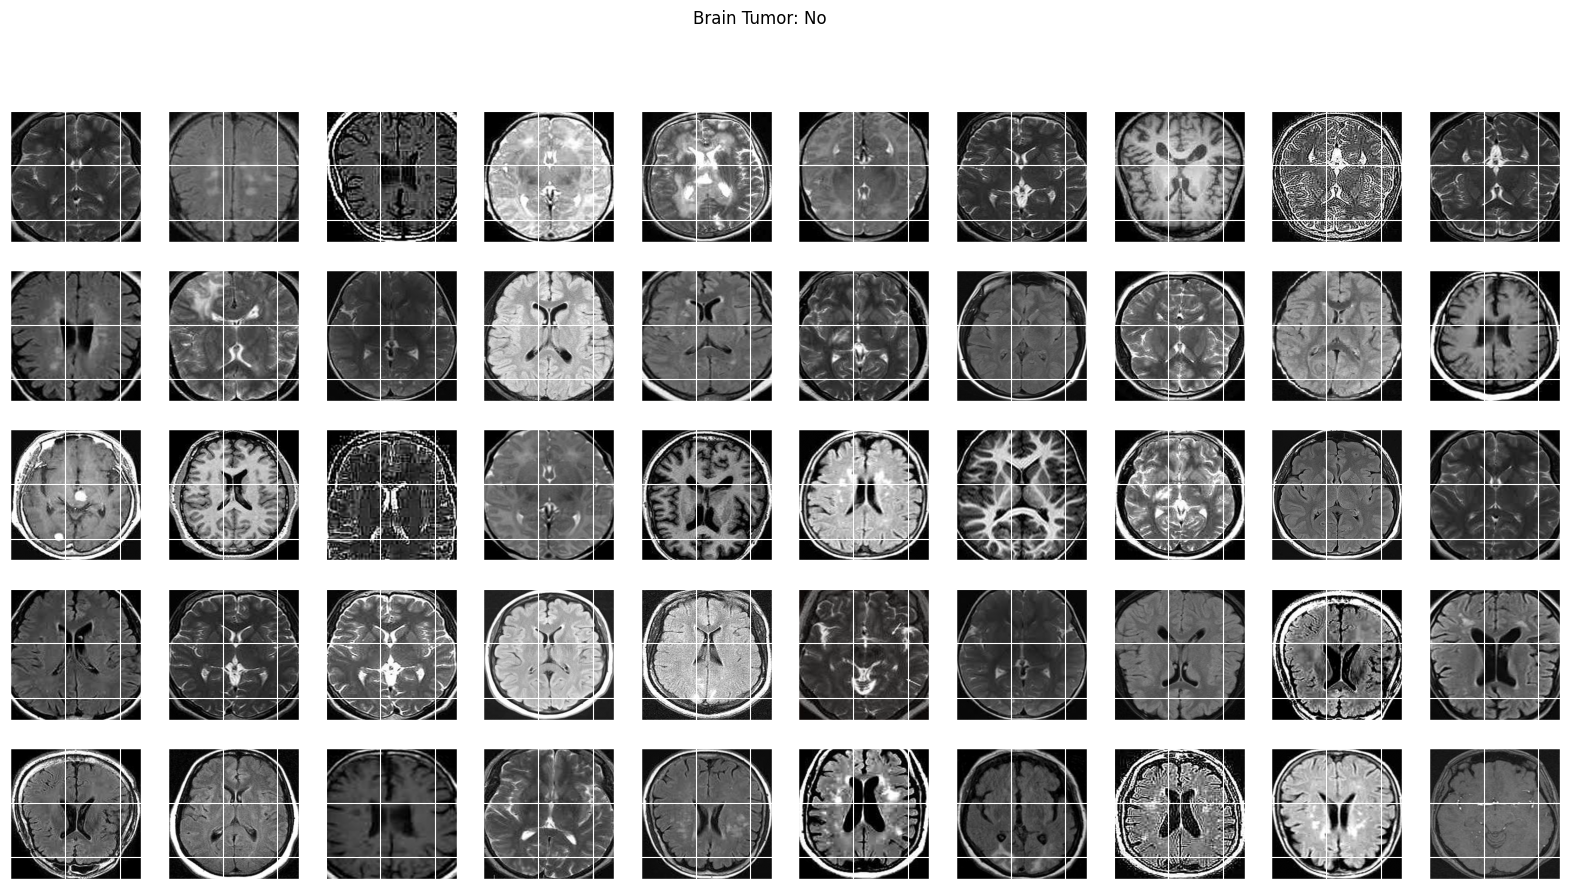

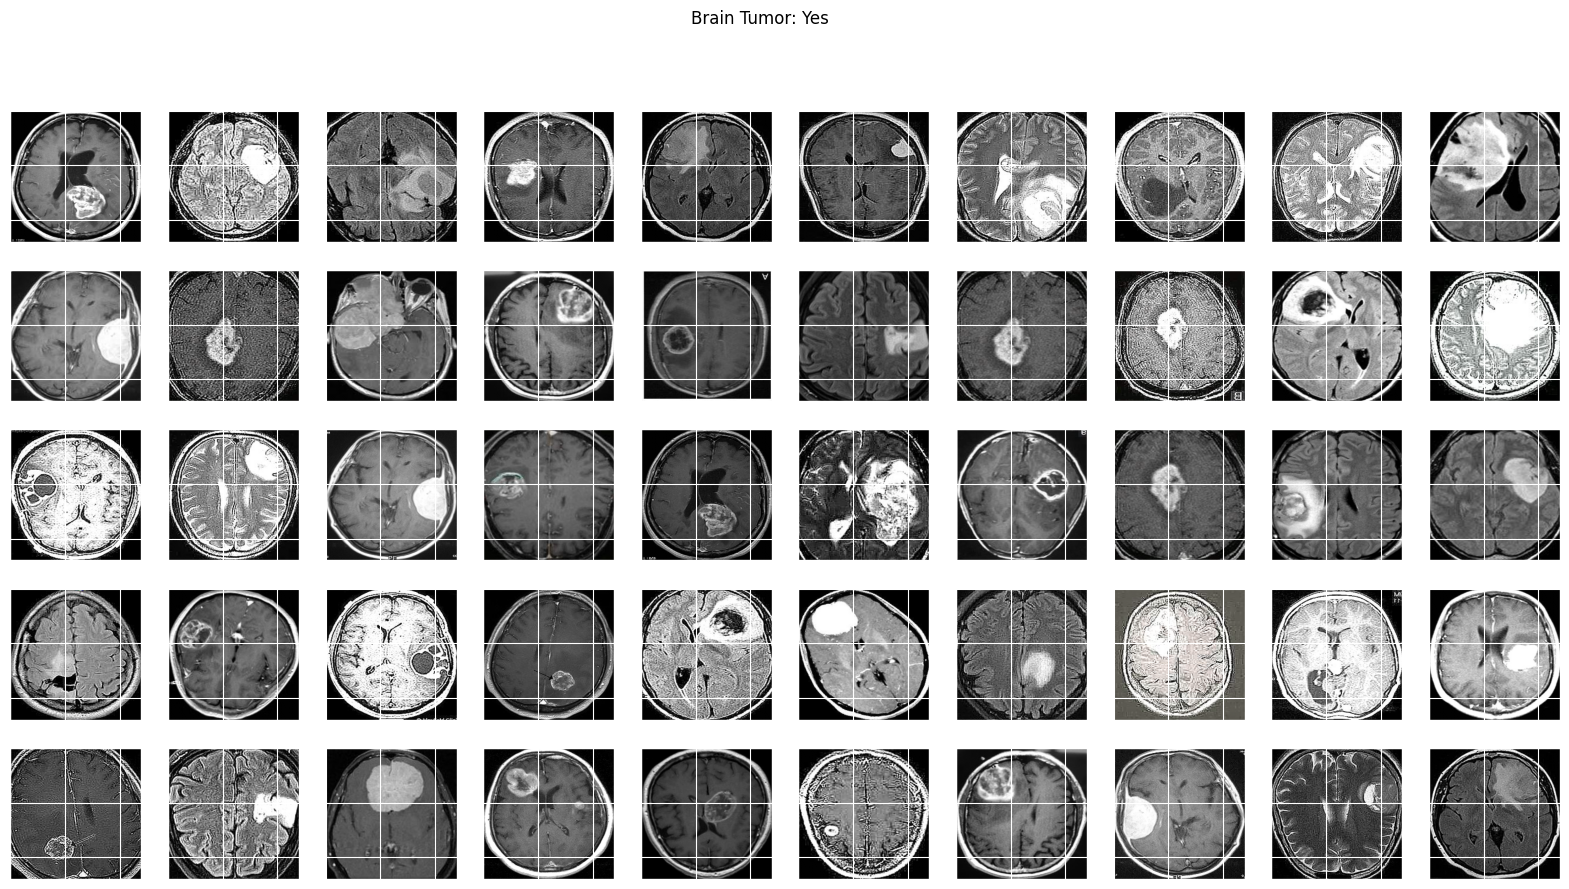

In [20]:
plot_sample_images(images, labels)

Data Splitting:
Train,
Test,
Validation

In [ ]:
import os
import shutil

# Define the base directory
base_dir = '/content/drive/My Drive/tumorous_and_nontumorous'

# Create the base directory if it doesn't exist
if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

# Define the train, test, and valid directories
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

# Create the train, test, and valid directories if they don't exist
for directory in [train_dir, test_dir, valid_dir]:
    if not os.path.isdir(directory):
        os.mkdir(directory)

# Define the tumorous and nontumorous directories
infected_train_dir = os.path.join(train_dir, 'tumorous')
infected_test_dir = os.path.join(test_dir, 'tumorous')
infected_valid_dir = os.path.join(valid_dir, 'tumorous')

healthy_train_dir = os.path.join(train_dir, 'nontumorous')
healthy_test_dir = os.path.join(test_dir, 'nontumorous')
healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')

# Create the tumorous and nontumorous directories if they don't exist
for directory in [infected_train_dir, infected_test_dir, infected_valid_dir,
                  healthy_train_dir, healthy_test_dir, healthy_valid_dir]:
    if not os.path.isdir(directory):
        os.mkdir(directory)

# Calculating the number of files for each category
num_tumorous_train = int(1750 * 0.8)
num_tumorous_test = int(1750 * 0.1)
num_tumorous_valid = int(1750 * 0.1)

num_nontumorous_train = int(1889 * 0.8)
num_nontumorous_test = int(1889 * 0.1)
num_nontumorous_valid = int(1889 * 0.1)

# Copy tumorous images to train, test, and valid directories
tumorous_files = os.listdir('/content/drive/My Drive/augmented_data/yes')
for i, fname in enumerate(tumorous_files):
    src = os.path.join('/content/drive/My Drive/augmented_data/yes', fname)
    if i < num_tumorous_train:
        dst = os.path.join(infected_train_dir, fname)
    elif i < num_tumorous_train + num_tumorous_test:
        dst = os.path.join(infected_test_dir, fname)
    else:
        dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

# Copy nontumorous images to train, test, and valid directories
nontumorous_files = os.listdir('/content/drive/My Drive/augmented_data/no')
for i, fname in enumerate(nontumorous_files):
    src = os.path.join('/content/drive/My Drive/augmented_data/no', fname)
    if i < num_nontumorous_train:
        dst = os.path.join(healthy_train_dir, fname)
    elif i < num_nontumorous_train + num_nontumorous_test:
        dst = os.path.join(healthy_test_dir, fname)
    else:
        dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

# Print the number of files copied to each directory
print("Tumorous images copied to train directory:", len(os.listdir(infected_train_dir)))
print("Tumorous images copied to test directory:", len(os.listdir(infected_test_dir)))
print("Tumorous images copied to valid directory:", len(os.listdir(infected_valid_dir)))
print()
print("Nontumorous images copied to train directory:", len(os.listdir(healthy_train_dir)))
print("Nontumorous images copied to test directory:", len(os.listdir(healthy_test_dir)))
print("Nontumorous images copied to valid directory:", len(os.listdir(healthy_valid_dir)))


Model Building

In [23]:
# Rescales pixel values to the range [0, 1], and applies various transformations such as
# horizontal and vertical flipping, rotation, shearing, and shifting to augment training images

train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 3639 images belonging to 2 classes.


In [ ]:
test_generator = test_data_gen.flow_from_directory('/content/drive/My Drive/tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical', shuffle=True, seed=42, color_mode='rgb')

Found 828 images belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_directory('/content/drive/My Drive/tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 1158 images belonging to 2 classes.


In [ ]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [ ]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [ ]:
# Define VGG19-based model architecture for binary classification
# It loads pre-trained VGG19, adds custom dense layers, and prints model summary

base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

In [ ]:
# Early stopping, model checkpointing, and reducing learning rate on plateau
filepath = 'model.h5'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [ ]:
sgd = SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 0.7256 - accuracy: 0.5250 
Epoch 1: val_loss improved from inf to 0.65994, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1326s 143s/step - loss: 0.7256 - accuracy: 0.5250 - val_loss: 0.6599 - val_accuracy: 0.6028 - lr: 1.0000e-04
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.5344 
Epoch 2: val_loss did not improve from 0.65994


10/10 [==============================] - 1287s 137s/step - loss: 0.6877 - accuracy: 0.5344 - val_loss: 0.6906 - val_accuracy: 0.5423 - lr: 1.0000e-04


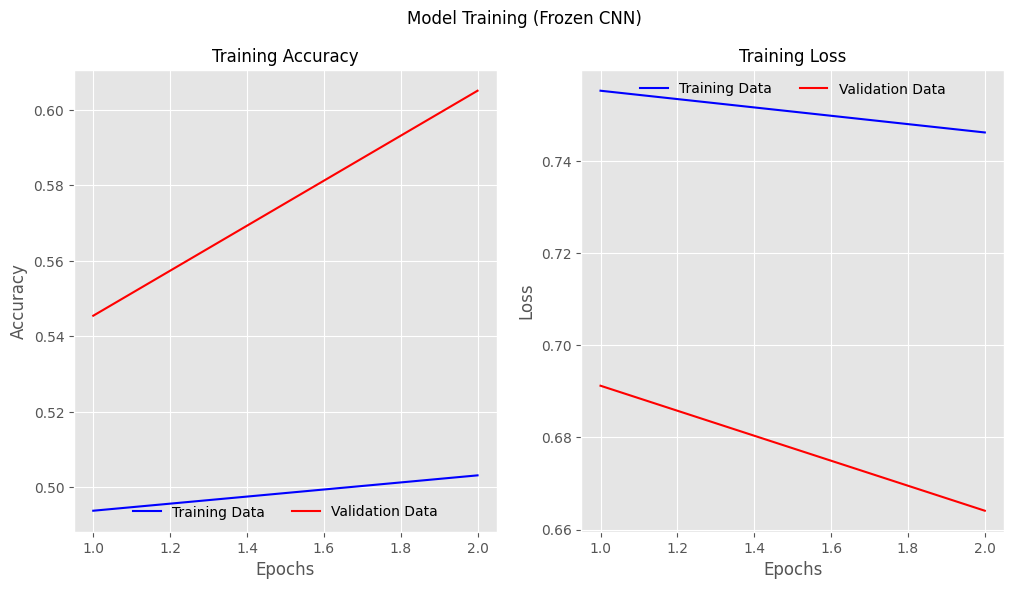

In [ ]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [ ]:
if not os.path.isdir('/content/drive/My Drive/model_weights/'):
    os.mkdir('/content/drive/My Drive/model_weights/')
model_01.save_weights(filepath="/content/drive/My Drive/model_weights/vgg19_model_01.h5", overwrite=True)

In [ ]:
model_01.load_weights("/content/drive/My Drive/model_weights/vgg19_model_01.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

23/23 [==============================] - 672s 29s/step - loss: 0.6764 - accuracy: 0.5510


In [ ]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.6595618724822998
Validation Acc: 0.6221590638160706
Testing Loss: 0.67641282081604
Testing Acc: 0.5509641766548157


In [ ]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

 23/726 [..............................] - ETA: 5:34:00

726/726 [==============================] - 658s 865ms/step


In [ ]:
# Incremental unfreezing and fine tuning

base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_3',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [ ]:
# Define base VGG19 model with specified input shape and excluding top layers
# Load pre-trained weights for the model
# Freeze layers up to a certain point in the base model

base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('/content/drive/My Drive/model_weights/vgg19_model_01.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [ ]:
sgd = SGD(learning_rate=0.0001, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 4, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/4
10/10 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.5437 
Epoch 1: val_loss improved from 0.66409 to 0.65429, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1352s 145s/step - loss: 0.7057 - accuracy: 0.5437 - val_loss: 0.6543 - val_accuracy: 0.6307 - lr: 1.0000e-04
Epoch 2/4
10/10 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.5656 
Epoch 2: val_loss did not improve from 0.65429


10/10 [==============================] - 1331s 143s/step - loss: 0.6939 - accuracy: 0.5656 - val_loss: 0.6875 - val_accuracy: 0.5360 - lr: 1.0000e-04
Epoch 3/4
10/10 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.6031 
Epoch 3: val_loss did not improve from 0.65429


10/10 [==============================] - 1325s 143s/step - loss: 0.6679 - accuracy: 0.6031 - val_loss: 0.6907 - val_accuracy: 0.5331 - lr: 1.0000e-04
Epoch 4/4
10/10 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.6062 
Epoch 4: val_loss improved from 0.65429 to 0.64736, saving model to model.h5


10/10 [==============================] - 1351s 146s/step - loss: 0.6531 - accuracy: 0.6062 - val_loss: 0.6474 - val_accuracy: 0.6155 - lr: 1.0000e-04


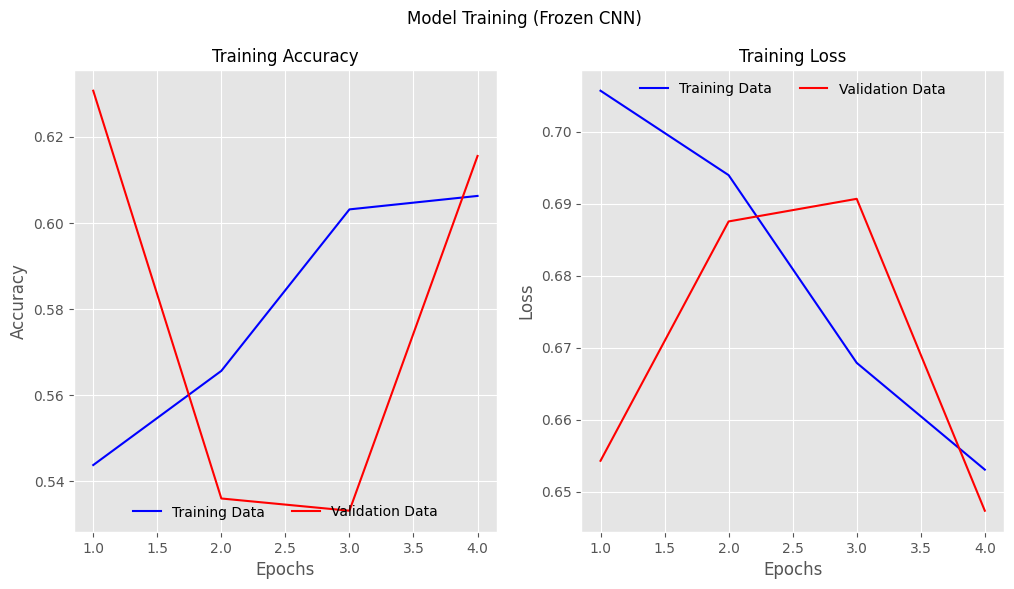

In [ ]:
# Plot performance
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_02.history['accuracy'])  # Get the actual number of epochs
epochs_list = list(range(1, max_epoch + 1))  # Adjust epochs_list accordingly

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [ ]:
if not os.path.isdir('/content/drive/My Drive/model_weights/'):
   os.mkdir('/content/drive/My Drive/model_weights/')
model_02.save_weights(filepath="/content/drive/My Drive/model_weights/vgg19_model_02.h5", overwrite=True)

In [ ]:
model_02.load_weights("/content/drive/My Drive/model_weights/vgg19_model_02.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

23/23 [==============================] - 652s 28s/step - loss: 0.5991 - accuracy: 0.7135


In [ ]:
# Unfreezing the entire network


base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names


x=base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)


model_03 = Model(base_model.inputs, output)
model_03.load_weights('/content/drive/My Drive/model_weights/vgg19_model_02.h5')


sgd = SGD(learning_rate=0.00001, momentum=0.9, nesterov=True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
model_03.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [ ]:
history_03 = model_03.fit(train_generator, steps_per_epoch = 10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.6687  
Epoch 1: val_loss improved from inf to 0.63915, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1943s 205s/step - loss: 0.6095 - accuracy: 0.6687 - val_loss: 0.6391 - val_accuracy: 0.6399 - lr: 1.0000e-05
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.6562  
Epoch 2: val_loss did not improve from 0.63915


10/10 [==============================] - 1938s 204s/step - loss: 0.6276 - accuracy: 0.6562 - val_loss: 0.6447 - val_accuracy: 0.6313 - lr: 1.0000e-05


In [ ]:
if not os.path.isdir('/content/drive/My Drive/model_weights/'):
    os.mkdir('/content/drive/My Drive/model_weights/')
model_03.save_weights(filepath="/content/drive/My Drive/model_weights/vgg_unfrozen.h5", overwrite=True)

In [ ]:
# Total accuracy & loss metrics

model_03.load_weights("/content/drive/My Drive/model_weights/vgg_unfrozen.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print(f'Validation Loss (Unfrozen): {vgg_val_eval_03[0]}')
print(f'Validation Accuracy (Unfrozen): {vgg_val_eval_03[1]}')
print(f'Testing Loss (Unfrozen): {vgg_test_eval_03[0]}')
print(f'Testing Accuracy (Unfrozen): {vgg_test_eval_03[1]}')

26/26 [==============================] - 662s 25s/step - loss: 0.5739 - accuracy: 0.7126
Validation Loss (Unfrozen): 0.6482221484184265
Validation Accuracy (Unfrozen): 0.6044905185699463
Testing Loss (Unfrozen): 0.5739133358001709
Testing Accuracy (Unfrozen): 0.7125604152679443
